## 1: MLP for FashionMNIST

### Overview

This project trains a Multi-Layer Perceptron (MLP) on the FashionMNIST dataset using PyTorch.

### Key Highlights

- **Model Architecture:** Utilizes fully connected layers with ReLU activations.
- **Optimization:** Stochastic Gradient Descent (SGD) is employed to optimize the model parameters.
- **Performance:** Achieves a validation accuracy of at least 82% after 8 epochs.
- **Training and Validation:** Training and validation loss, along with accuracy, are plotted to visualize model performance and convergence.
- **Implementation Details:** Includes data loading, model definition, training loop implementation, and visualization using matplotlib.

In [11]:
#import library
import numpy as np
import torch.nn as nn
import torchvision
import torch.utils.data
import torchvision.transforms as transforms

In [12]:
# define base transform
# load data
# caculate mean and stds
transform = transforms.Compose([transforms.ToTensor()])
data_set = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
print(data_set.data.float().mean() / 255)
print(data_set.data.float().std() /255)

100%|██████████| 26421880/26421880 [00:01<00:00, 16015462.77it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273717.77it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5091718.91it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5331426.42it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

tensor(0.2860)
tensor(0.3530)


In [13]:
# relaod and normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2860, ), (0.3530, ))])
data_set = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
validate_set = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [14]:
# set the cuda device
# get the loader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_data_loader= torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True, num_workers=8)
valid_data_loader = torch.utils.data.DataLoader(validate_set, batch_size=64, shuffle=False, num_workers=8)
print(len(train_data_loader))
print(len(valid_data_loader))

938
157


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
# get the classes and class size
classes = data_set.classes
print(classes)
print(len(classes))

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10


In [20]:
# MLP net
class MLPNet(nn.Module):
  def __init__(self, num_classes=10):
    super(MLPNet, self).__init__()
    self.classifier= nn.Sequential(
        # 1 dropt out -> linear -> noramlize -> relu -> Dropout
        nn.Dropout(), nn.Linear(28 * 28, 512), nn.BatchNorm1d(512), nn.LeakyReLU(inplace=True) , nn.Dropout(),
        # 2 linear -> noramlize -> relu
         nn.Linear(512, 256), nn.BatchNorm1d(256), nn.LeakyReLU(inplace=True) ,
        # 3 linear -> noramlize -> relu -> dropout
         nn.Linear(256, 128), nn.BatchNorm1d(128), nn.LeakyReLU(inplace=True) , nn.Dropout(),
        # 4 linear -> noramlize -> relu -> dropout
         nn.Linear(128, 64), nn.BatchNorm1d(64), nn.LeakyReLU(inplace=True),
        # 6 linear
         nn.Linear(64, 10))

  def forward(self, x):
        x=x.view(x.size(0), 28 * 28)
        x= self.classifier(x)
        return x
model= MLPNet(num_classes=10).to(device)
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model.parameters(), lr=0.0001)

In [21]:
training_losses_lst=[]
validate_losses_lst=[]
train_accuracy_list = []
validate_accuracy_list = []
epochs = 8

for epoch in range(epochs):


    train_loss = 0
    validate_loss = 0

    validate_accuracy = 0
    train_accuracy = 0

    # thrain the data
    model.train()
    for i, (data, target) in enumerate(train_data_loader):

        inputs, labels= data.to(device), target.to(device)

        #set parameter gradients to zero
        optimizer.zero_grad()
        # get the output passing the input to model
        outputs= model(inputs)
        # calculate the loss
        loss = criterion(outputs, labels)
        # comput the gradients
        loss.backward()
        # update parameter
        optimizer.step()
        # accumulate the loss of that batch
        train_loss += loss.item()
    training_losses_lst.append(train_loss/len(train_data_loader))
    print(f"epoch {epoch+1}, training loss: {training_losses_lst[-1]}")

    #evaluation mode
    model.eval()
    with torch.no_grad():
        # get the accuracy of the train set
        total_size = 0
        for i, (data, target) in enumerate(train_data_loader):
            inputs, labels= data.to(device), target.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_size += labels.size(0)
            train_accuracy += (predicted==labels).sum().item()
        train_accuracy_list.append(train_accuracy / total_size)
        # loop throught the batch in validation set
        print(f"epoch {epoch+1}, train accuracy: {train_accuracy_list[-1]}")

        # get the loss and the accuracy of the validate set
        total_size = 0
        for i, (data, target) in enumerate(valid_data_loader):

            inputs, labels= data.to(device), target.to(device)
            outputs = model(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)
            validate_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_size += labels.size(0)
            validate_accuracy += (predicted==labels).sum().item()
    validate_losses_lst.append(validate_loss / len(valid_data_loader))
    validate_accuracy_list.append(validate_accuracy / total_size)
    print(f"epoch {epoch+1}, validate accuracy: {validate_accuracy_list[-1]}")

epoch 1, training loss: 1.2731797250984573
epoch 1, train accuracy: 0.78555
epoch 1, validate accuracy: 0.7765
epoch 2, training loss: 0.7205420913599702
epoch 2, train accuracy: 0.8264333333333334
epoch 2, validate accuracy: 0.8158
epoch 3, training loss: 0.6167868133356322
epoch 3, train accuracy: 0.8416166666666667
epoch 3, validate accuracy: 0.8339
epoch 4, training loss: 0.5703145304659029
epoch 4, train accuracy: 0.8452333333333333
epoch 4, validate accuracy: 0.8368
epoch 5, training loss: 0.5504002866905127
epoch 5, train accuracy: 0.8539333333333333
epoch 5, validate accuracy: 0.8433
epoch 6, training loss: 0.5282772183577135
epoch 6, train accuracy: 0.8567833333333333
epoch 6, validate accuracy: 0.8487
epoch 7, training loss: 0.5133884019657239
epoch 7, train accuracy: 0.8606333333333334
epoch 7, validate accuracy: 0.8475
epoch 8, training loss: 0.5070149242750871
epoch 8, train accuracy: 0.8634833333333334
epoch 8, validate accuracy: 0.8533


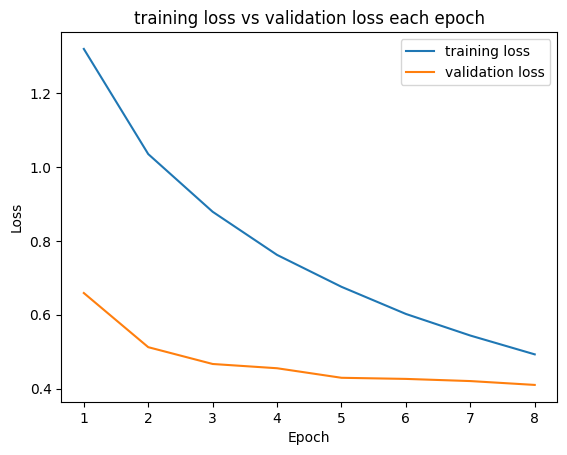

In [40]:
import matplotlib.pyplot as plt
epoches = [i for i in range(1, 9)]
plt.plot(epoches, training_losses_lst, label="training loss")
plt.plot(epoches, validate_losses_lst, label="validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('training loss vs validation loss each epoch')
plt.show()

Text(0.5, 1.0, 'training vs validate accuracy each epoch')

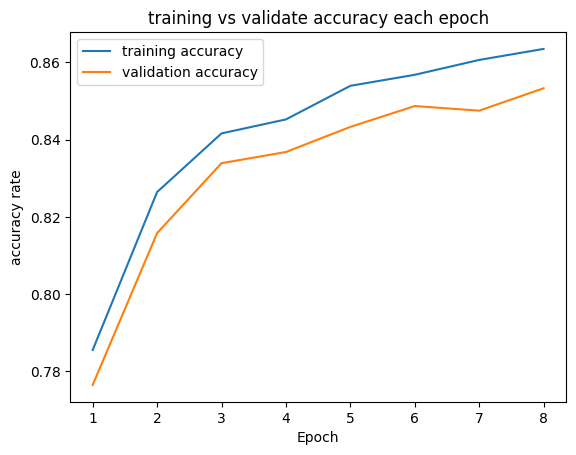

In [38]:
plt.plot(epoches, train_accuracy_list, label='training accuracy')
plt.plot(epoches, validate_accuracy_list, label='validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('accuracy rate')
plt.title('training vs validate accuracy each epoch')

## 2: CIFAR-10 CNN with AlexNet Architecture

### Overview

This project implements a Convolutional Neural Network (CNN) using the AlexNet architecture to classify CIFAR-10 images.

### Workflow

- **Data Preprocessing:** Applies normalization and augmentation using computed mean and standard deviation values.
- **Dataset Handling:** Loads CIFAR-10 dataset, applies transformations, and creates efficient data loaders for batch processing.
- **Model Architecture:** Implements AlexNet with convolutional layers, ReLU activations, and fully connected layers from scratch, without pre-trained weights.
- **Training Process:** Optimizes model parameters using SGD, tracks training progress with loss per epoch.
- **Validation and Accuracy:** Evaluates model performance on a validation set to prevent overfitting, achieving competitive accuracy on the CIFAR-10 test set.

In [44]:
import numpy as np
import pandas as pd
import os
import torch.nn as nn
import torchvision
import torch.utils.data
import torchvision.transforms as transforms

# process
1. base transform
2. get the data set
3. caculate the mean and std
4. get the new transform use the mean and std we caculate above
5. get the data set again
6. get the loader
7. split the data into training and validate data
8. define AlexNet neural net model
9. train the data define loss during each pouch
10. get the accuracy of validation data

In [45]:
# caculate the mean and std for normalize in transformation
# base transform
transform = transforms.Compose([transforms.ToTensor()])
data_set = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform,
                                      download=True)
print(data_set.data.mean(axis = (0, 1, 2)) / 255)
print(data_set.data.std(axis = (0, 1, 2)) / 255)

Files already downloaded and verified
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [46]:
# get ttransform= transforms.Compose(
transform = transforms.Compose([transforms.Resize(256), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223 , 0.24348513, 0.26158784])])
data_set = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform,
                                      download=True)

Files already downloaded and verified


In [47]:
# get the classes
classes = data_set.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [48]:
# set the cuda device
# get the loader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader= torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True,
                                        num_workers=8)
# get number of batches
num_batches = len(train_loader)
print(num_batches)

782


In [49]:
# split the data loader into train and valid subset
idxs= np.random.permutation(num_batches)
train_idxs, valid_idxs= idxs[round(num_batches//4):], idxs[:round(num_batches//4)]

train_data_loader = torch.utils.data.Subset(train_loader, train_idxs)
valid_data_loader = torch.utils.data.Subset(train_loader, valid_idxs)
print(len(train_data_loader))
print(len(valid_data_loader))

587
195


In [50]:
# define AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):

        super(AlexNet, self).__init__()

        # convolutional neural network
        #cnn layer 1
        self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        #cnn layer 2
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        #cnn layer 3
        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #cnn layer 4
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #cnn layer 5
        nn.Conv2d(384, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # fully connected neural network
        self.fc = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256*6*6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, num_classes))

    def forward(self, x):
        x= self.cnn(x)
        x=x.view(x.size(0), 256*6*6)
        x= self.fc(x)
        return x

model= AlexNet(num_classes=10).to(device)
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model.parameters(), lr=0.0001)

In [51]:
training_losses_lst=[]
accuracy_list = []
epochs = 14

for epoch in range(epochs):
    model.train()
    train_loss = 0
    accuracy = 0

    # loop throug the batches
    for i, (data, target) in enumerate(train_data_loader.dataset):

        inputs, labels= data.to(device), target.to(device)

        #set parameter gradients to zero
        optimizer.zero_grad()
        # get the output passing the input to model
        outputs= model(inputs)
        # calculate the loss
        loss = criterion(outputs, labels)
        # comput the gradients
        loss.backward()
        # update parameter
        optimizer.step()
        # accumulate the loss of that batch
        train_loss += loss.item()
    training_losses_lst.append(train_loss/len(train_data_loader))
    print(f"epoch {epoch+1}, training loss: {training_losses_lst[-1]}")

    #evaluation mode
    model.eval()
    total_size = 0
    with torch.no_grad():
        # loop throught the batch in validation set
        for i, (data, target) in enumerate(valid_data_loader.dataset):

            inputs, labels= data.to(device), target.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total_size += labels.size(0)
            accuracy += (predicted==labels).sum().item()
    accuracy_list.append(accuracy / total_size)
    print(f"epoch {epoch+1}, accuracy: {accuracy_list[-1]}")

epoch 1, training loss: 1.964767853385139
epoch 1, accuracy: 0.60914
epoch 2, training loss: 1.3082136888520275
epoch 2, accuracy: 0.73446
epoch 3, training loss: 1.0296814097964175
epoch 3, accuracy: 0.75602
epoch 4, training loss: 0.8678833842277527
epoch 4, accuracy: 0.8206
epoch 5, training loss: 0.7587825527995368
epoch 5, accuracy: 0.84006
epoch 6, training loss: 0.6833301074866339
epoch 6, accuracy: 0.86898
epoch 7, training loss: 0.6046474851680573
epoch 7, accuracy: 0.86832
epoch 8, training loss: 0.5406669596847927
epoch 8, accuracy: 0.89356
epoch 9, training loss: 0.49096146481051356
epoch 9, accuracy: 0.91596
epoch 10, training loss: 0.4393627750457247
epoch 10, accuracy: 0.91178
epoch 11, training loss: 0.3915834028457864
epoch 11, accuracy: 0.9294
epoch 12, training loss: 0.350538712699328
epoch 12, accuracy: 0.94516
epoch 13, training loss: 0.31587991527768783
epoch 13, accuracy: 0.9451
epoch 14, training loss: 0.2814834406710463
epoch 14, accuracy: 0.95954


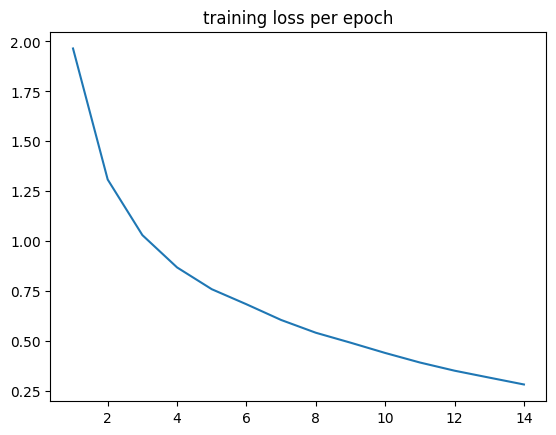

In [52]:
epoches = [i for i in range(1, 15)]
plt.plot(epoches, training_losses_lst, label="training loss")
plt.title('training loss per epoch')
plt.show()

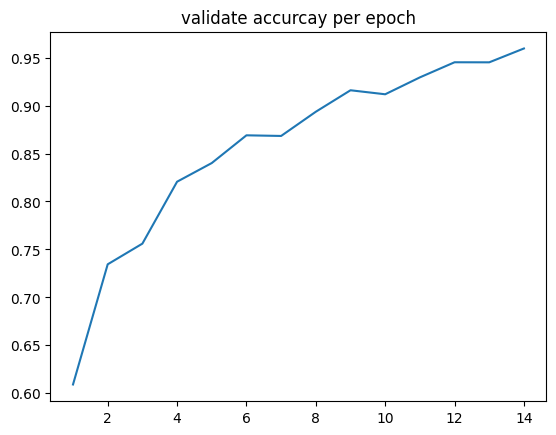

In [54]:
epoches = [i for i in range(1, 15)]
plt.plot(epoches, accuracy_list, label="validate accuracy")
plt.title('validate accurcay per epoch')
plt.show()

### Kaggle Submission
The following code is for you to make your submission to kaggle. Here are the steps you must follow:

1. Upload `cifar_test_data_sp24.npy` to the colab notebook by going to files on the left hand pane, then hitting "upload". This file may take roughly a minute to upload and you should not proceed to the following steps until it has completely finished uploading (students in the past have run into issues where they were accidentally testing on a partially uploaded test set and getting garbage results).
2. Run the following cell to generate the dataset object for the test data. Feel free to modify the code to use the same transforms that you use for the training data. By default, this will re-use the `transform` variable.
3. In the second cell, write code to run predictions on the testing dataset and store them into an array called `predictions`.
4. Run the final cell which will convert your predictions array into a CSV for kaggle.
5. Go to the files pane again, and download the file called `submission.csv` by clicking the three dots and then download.


In [56]:
from PIL import Image
import os

class CIFAR10Test(torchvision.datasets.VisionDataset):

    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("cifar10_test_data_sp24.npy"), "You must upload the test data to the file system."
        self.data = [np.load("cifar10_test_data_sp24.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform, # NOTE: Make sure transform is the same as used in the training dataset.
)

In [57]:
### YOUR CODE HERE ###

# Recommendation: create a `test_dataloader` from torch.utils.data.DataLoader with `shuffle=False` to iterate over the test data in batches.

# Store a numpy vector of the predictions for the test set in the variable `predictions`.
predictions = []
model.eval()
total_size = 0
test_loader= torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=False,
                                        num_workers=8)
with torch.no_grad():
    # loop throught the batch in test set
    for i, data in enumerate(test_loader):
        inputs = data.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        predictions += predicted.cpu().numpy().tolist()


In [58]:
predictions = np.array(predictions)
print(predictions)

[2 1 1 ... 7 5 3]


In [59]:
# This code below will generate kaggle_predictions.csv file. Please download it and submit to kaggle.
import pandas as pd

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1.
df.to_csv('submission.csv', index_label='Id')

# Now download the submission.csv file to submit.

Congrats! You made it to the end.